In [60]:
import pandas as pd
df = pd.read_excel(r"C:\Users\Shrow\manufacturing_quality_control\data\relevant_quality_control_dataset_plain_time.xlsx")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   batch_id          100 non-null    object
 1   start_time        100 non-null    object
 2   end_time          100 non-null    object
 3   total_units       100 non-null    int64 
 4   defective_units   100 non-null    int64 
 5   status            100 non-null    object
 6   downtime_minutes  100 non-null    int64 
 7   defect_cause      19 non-null     object
dtypes: int64(3), object(5)
memory usage: 6.4+ KB


,batch_id,start_time,end_time,total_units,defective_units,status,downtime_minutes,defect_cause
0,BATCH_001,2025-01-01 08:00:00,2025-01-01 09:00:00,825,63,pass,0,NaN
1,BATCH_002,2025-01-01 09:00:00,2025-01-01 10:00:00,1185,29,pass,5,NaN
2,BATCH_003,2025-01-01 10:00:00,2025-01-01 11:00:00,1046,35,pass,10,NaN
3,BATCH_004,2025-01-01 11:00:00,2025-01-01 12:00:00,890,77,pass,10,NaN
4,BATCH_005,2025-01-01 12:00:00,2025-01-01 13:00:00,1034,56,pass,0,NaN


In [16]:
import sqlite3
# connect to sqlLite DB
conn = sqlite3.connect(r"C:\Users\Shrow\manufacturing_quality_control\data\quality_control.db")

                    

# saving the DataFrame to a table called 'batches'
df.to_sql('batches', conn, if_exists='replace', index=False)

100

In [55]:
df.shape
df.head()

,batch_id,start_time,end_time,total_units,defective_units,status,downtime_minutes,defect_cause
0,BATCH_001,2025-01-01 08:00:00,2025-01-01 09:00:00,825,63,pass,0,NaN
1,BATCH_002,2025-01-01 09:00:00,2025-01-01 10:00:00,1185,29,pass,5,NaN
2,BATCH_003,2025-01-01 10:00:00,2025-01-01 11:00:00,1046,35,pass,10,NaN
3,BATCH_004,2025-01-01 11:00:00,2025-01-01 12:00:00,890,77,pass,10,NaN
4,BATCH_005,2025-01-01 12:00:00,2025-01-01 13:00:00,1034,56,pass,0,NaN


In [19]:
conn = sqlite3.connect(r"C:\Users\Shrow\manufacturing_quality_control\data\quality_control.db")
df.to_sql('batches', conn, if_exists='replace', index=False)


100

In [20]:
pd.read_sql("SELECT COUNT(*) FROM batches", conn)


,COUNT(*)
0,100


In [63]:
# To run sql query
def run_query(sql):
    return pd.read_sql(sql, conn)

# here total defects / total batches gives us defect rate
query = """
SELECT
    COUNT(*) AS total_batches,
    SUM(defective_units) AS total_defects,
    SUM(defective_units) * 1.0 / COUNT(*) AS defect_rate
FROM batches
"""

# Run the query and display results
run_query(query)

,total_batches,total_defects,defect_rate
0,100,5371,53.71


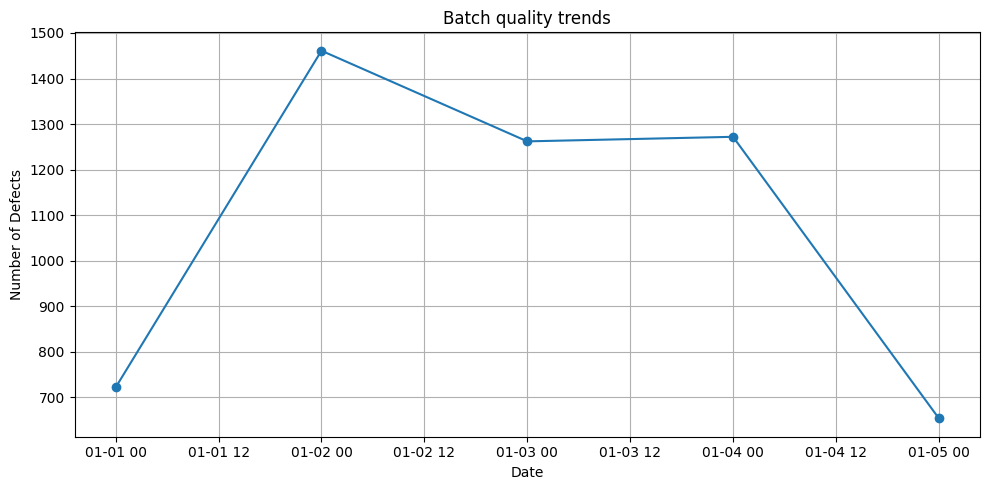

In [61]:
import matplotlib.pyplot as plt

# Grouping by day or hour
df['start_time'] = pd.to_datetime(df['start_time'])
df_by_day = df.groupby(df['start_time'].dt.date)['defective_units'].sum()

# plot
plt.figure(figsize=(10, 5))
df_by_day.plot(marker='o')
plt.title('Batch quality trends')
plt.xlabel('Date')
plt.ylabel('Number of Defects')
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
def run_query(sql):
    return pd.read_sql(sql, conn)

query = """
SELECT 
    SUM(downtime_minutes) * 1.0 / 
    SUM((JULIANDAY(end_time) - JULIANDAY(start_time)) * 24 * 60) AS downtime_rate
FROM batches;
"""

downtime_result = run_query(query)
print(downtime_result)


   downtime_rate
0           0.04


In [62]:
import pandas as pd
import sqlite3

# loading dataset
df = pd.read_excel(r"C:\Users\Shrow\manufacturing_quality_control\data\relevant_quality_control_dataset_plain_time.xlsx")

# Connect to sqllite DB
conn = sqlite3.connect(':memory:')

# Save the DataFrame to a table named 'batches'
df.to_sql('batches', conn, index=False, if_exists='replace')

# sequel to calculate batch failure rate
query = """
SELECT 
    COUNT(CASE WHEN LOWER(status) = 'defective' THEN 1 END) * 1.0 / COUNT(*) AS batch_failure_rate
FROM batches;
"""

# Execute the query
result = pd.read_sql(query, conn)

# Display result
print("Batch Failure Rate:")
display(result)


Batch Failure Rate:


,batch_failure_rate
0,0.19


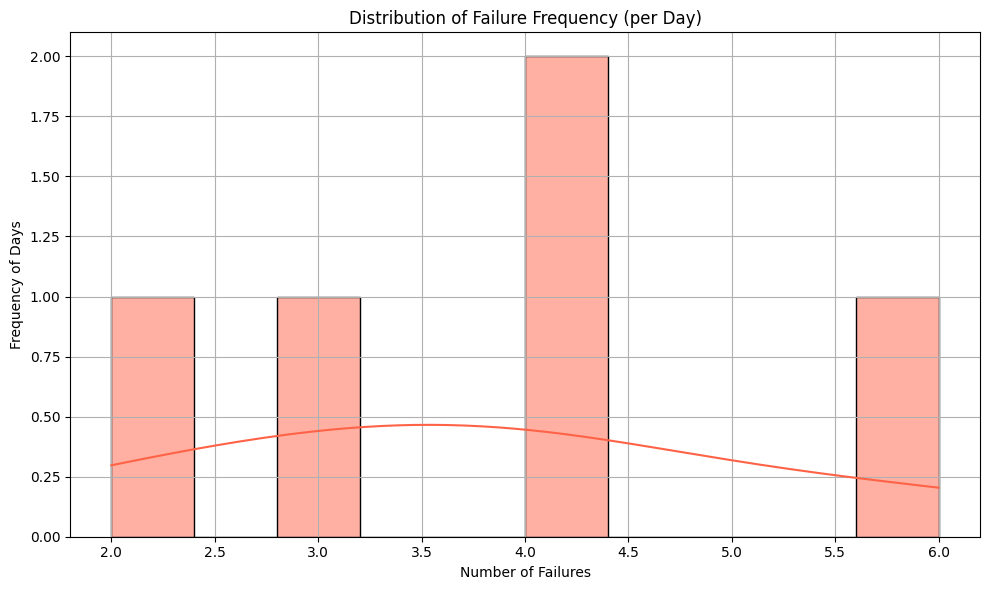

In [51]:
# ensuring 'start_time' is datetime
df['start_time'] = pd.to_datetime(df['start_time'])

# filtering only defective batches
failures = df[df['status'].str.lower() == 'defective'].copy()

# extract date part to group by day
failures['failure_date'] = failures['start_time'].dt.date

# count failures per day
failures_per_day = failures.groupby('failure_date').size().reset_index(name='failures')

# Plot distribution of daily failure counts
plt.figure(figsize=(10, 6))
sns.histplot(failures_per_day['failures'], bins=10, kde=True, color='tomato')
plt.title('Distribution of Failure Frequency (per Day)')
plt.xlabel('Number of Failures')
plt.ylabel('Frequency of Days')
plt.grid(True)
plt.tight_layout()
plt.show()

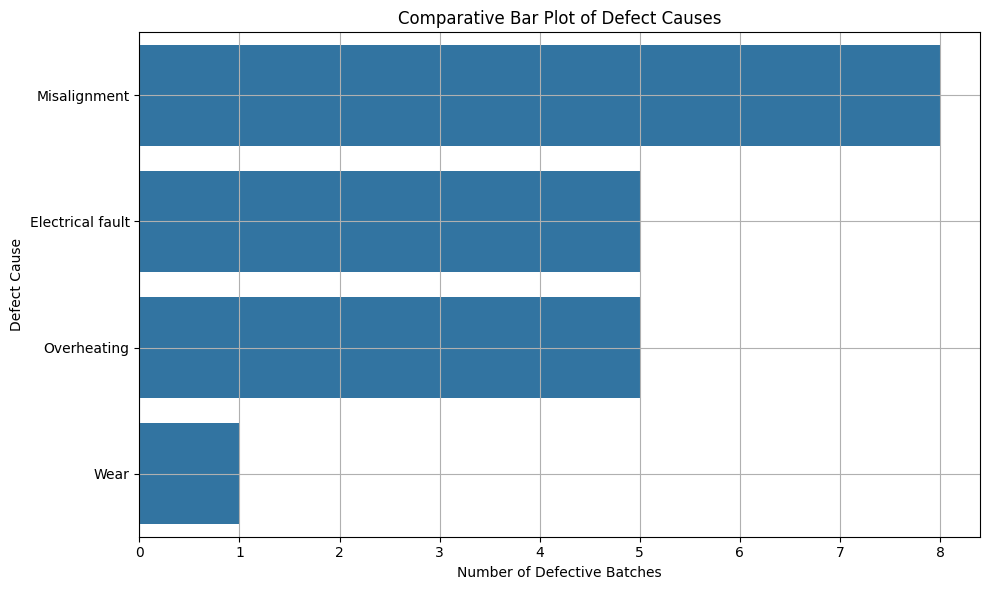

In [64]:
# filter defective batches
defective_batches = df[df['status'].str.lower() == 'defective']

# counting the occurrences of each defect cause
defect_counts = defective_batches['defect_cause'].value_counts().reset_index()
defect_counts.columns = ['defect_cause', 'count']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=defect_counts, x='count', y='defect_cause')
plt.title('Comparative Bar Plot of Defect Causes')
plt.xlabel('Number of Defective Batches')
plt.ylabel('Defect Cause')
plt.grid(True)
plt.tight_layout()
plt.show()